## Mobile Games A/B Testing - Cookie Cats

## Introduction

This dataset contains the results of an A/B test conducted in the mobile game Cookie Cats to analyze the impact of changing the placement of the first gate in the game. Each player was randomly assigned to either group upon installing the game, ensuring an unbiased comparison between the two versions.

## Goal

Assuming that company's primary objective was to maximize players engagement:
To evaluate the imapct of the change in the gate position to the total number of game rounds played during the first 14 days to the player engagement and determine more optimal position.

## Target Metric

Average number of game rounds played per player during the first 14 days after installing the game.

By analyzing this metric, the A/B test can provide actionable insights into whether moving the gate from level 30 to level 40 enhances engagement and determines the more optimal position for the gate.

Groups:
 - Control group: Players assigned to the gate_30 version, where the first gate is placed at level 30.
 - Treatment group: Players assigned to the gate_40 version, where the first gate is moved to level 40.

Concerns:

*  Definition of game rounds: the event that begins when a player starts playing and ends when the round is either completed or the player loses (e.g. time runs out, lost all lives). Additional clarification on what constitutes a "game round" is needed.

* Outliers: While playing 420–560 game rounds over two weeks (30–40 rounds per day) seems plausible, 1000 game rounds per week would equate to over 70 rounds per day, which appears excessive. This could only make sense if a "game round" ends upon losing, and players with extremely high counts are simply losing frequently. Verification that the data was collected accurately is needed.

* Players that have not reached level 30 or 40, should be filtered out, although with the current assumption on what game round it is impossible to do with the information that is present in the dataset.

    * But we can filter out users who have not played 30 or 40 rounds. And have not had a chance to reach their gate.

    

## Formulating Hypothesis

- Null Hypothesis (H0):

    * The mean values of game rounds played are the same for both gate versions (gate_30 and gate_40). No version has a statistically significant impact on game rounds compared to the other.
    * H0: μ1 == μ2 
- Alternative Hypothesis (Ha):

    * One version has a different mean value of game rounds played than the other.
    * Ha: μ1 != μ2

## Objectives

1. **Data Preparation**
   - Loading and cleaning the dataset
   - Handling missing values and outliers
   - Identifying categorical and numerical features

2. **Retention Analysis**
   - Calculate overall 1-day and 7-day retention rates
   - Compare retention rates between the control and treatment groups

3. **Game Rounds Analysis**
   - Analyze the distribution of game rounds played
   - Identify patterns and outliers in game rounds data

4. **A/B Testing**
   - Formulate hypotheses for A/B testing
   - Conduct statistical tests to compare the two versions of the game
   - Interpret the results and determine statistical significance

5. **Conclusion and Recommendations**
   - Summarize key findings from the analysis
   - Provide actionable recommendations based on the results
   - Suggest future improvements for further analysis

## 1. Importing Necessary Libraries



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from utils.eda_utils import (
    check_missing_values,
    check_duplicates,
    find_outlier_rows_by_iqr,
)


from utils.utils import (
     draw_boxplot,
     draw_histplot,
     draw_barplot,
     draw_gates_plot,
     plot_mean_game_rounds_with_ci,
     )

from utils.stats_utils import bootstrap_mean_ci




In [3]:
import warnings
sns.set_theme(style="whitegrid", palette="deep")
warnings.filterwarnings('ignore')

## 2. **Load and Inspect the Dataset**

In [4]:
mobile_game_df = pd.read_csv("cookie_cats.csv")
mobile_game_df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## 3. Dataset Overview

The goal is to understand data characteristics.

In [5]:
mobile_game_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


Note on columns:

- userid: A unique number that identifies each player.
- version: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
- sum_gamerounds: the number of game rounds played by the player during the first 14 days after install.
- retention_1: Did the player come back and play 1 day after installing?
- retention_7: Did the player come back and play 7 days after installing?

In [6]:
mobile_game_df.describe()
mobile_game_df['sum_gamerounds'].agg(["count", "median", "mean", "std", "max"])

count     90189.000000
median       16.000000
mean         51.872457
std         195.050858
max       49854.000000
Name: sum_gamerounds, dtype: float64

Note on game rounds summary:

- There are some extreme outlies in game rounds metrics, maximum value is close to 50k, while 75% of values fall below 51, which is 1k difference.
- sum_gamerounds variable may not be normally distributed due to big difference between mean and amedian is 16, while the mean is 51.9.
<!-- - idomu kad minimumas 0, tai yra vartotoju,  kurie  instaliavo ir nezaide? -->

check Unique values per column

In [7]:
unique_counts = {col: mobile_game_df[col].nunique() for col in mobile_game_df.columns}
display(
    pd.DataFrame.from_dict(unique_counts, orient="index", columns=["Unique Values"])
)

,Unique Values
userid,90189
version,2
sum_gamerounds,942
retention_1,2
retention_7,2


In [8]:
mobile_game_df['sum_gamerounds'].value_counts().sort_index()

sum_gamerounds
0        3994
1        5538
2        4606
3        3958
4        3629
         ... 
2294        1
2438        1
2640        1
2961        1
49854       1
Name: count, Length: 942, dtype: int64

## 4. Data Cleaning and Preprocessing

* ### Missing and Duplicate Values

In [9]:
check_missing_values(df=mobile_game_df)

The dataset does not contain any missing values.


In [10]:
check_duplicates(mobile_game_df)

No duplicate rows found based on the columns: None


In [11]:
check_duplicates(
    df=mobile_game_df,
    column_names=[
        "userid",
    ],
)

No duplicate rows found based on the columns: ['userid']


* ###  Zero rounds
Next, I will check for users who have installed the game, but have not played any rounds.
 The total number of game rounds should be equal to zero.

In [12]:
mobile_game_df["sum_gamerounds"].value_counts()

sum_gamerounds
1       5538
2       4606
0       3994
3       3958
4       3629
        ... 
572        1
2063       1
846        1
768        1
708        1
Name: count, Length: 942, dtype: int64

In [13]:
zero_rounds_df = mobile_game_df[mobile_game_df["sum_gamerounds"] == 0]
zero_rounds_df["version"].value_counts()

version
gate_40    2057
gate_30    1937
Name: count, dtype: int64

In [14]:
zero_rounds_df.shape

(3994, 5)

* 3,994 user IDs who have installed the app, but their total rounds played is zero
* 2057 users from gate_40 group.
* 1937 users from gate_30 group.


Note on zero rounds: these entries can be filtered out, as no matter the game definition (level or an event from start to end), players with zero rounds certainly have not reached gate_30 / gate_40.

In [15]:

before_gate_rounds_df = mobile_game_df[
    (mobile_game_df["sum_gamerounds"] == 0) |
    ((mobile_game_df["sum_gamerounds"] < 30) & (mobile_game_df["version"] == "gate_30")) |
    ((mobile_game_df["sum_gamerounds"] < 40) & (mobile_game_df["version"] == "gate_40"))
]

mobile_game_df_clean = mobile_game_df[
    ~mobile_game_df["userid"].isin(before_gate_rounds_df["userid"])
]

print(before_gate_rounds_df["version"].value_counts())

mobile_game_df_clean.describe()

version
gate_40    31662
gate_30    28044
Name: count, dtype: int64


,userid,sum_gamerounds
count,3.048300e+04,30483.000000
mean,5.002516e+06,133.056950
std,2.875253e+06,320.054177
min,3.370000e+02,30.000000
25%,2.525454e+06,50.000000
50%,4.990732e+06,81.000000
75%,7.481858e+06,154.000000
max,9.999768e+06,49854.000000


## 5. Exploratory Data Analysis
The goal is to explore the data’s characteristics and gain an initial understanding of patterns, distributions, and relationships within the dataset.

## Randomization Check
Testing for sample ratio mismatch (SRM) using Chi-Square Goodness-of-Fit test.

In [16]:

gate_version_counts = mobile_game_df_clean["version"].value_counts()
expected_counts = [
    len(mobile_game_df_clean) / gate_version_counts.size
] * gate_version_counts.size

chi2_stat, p_value = stats.chisquare(f_obs=gate_version_counts, f_exp=expected_counts)

print(f"Chi2 Statistic: {chi2_stat:.2f}, P-value: {p_value:.4f}\n")
if p_value < 0.05:
    print("Sample Ratio Mismatch detected!")
else:
    print("No Sample Ratio Mismatch detected.")

Chi2 Statistic: 262.55, P-value: 0.0000

Sample Ratio Mismatch detected!


Note on mismatch handling: techniques that are not sensitive to different sample size will be used to mitigate mismatched sample ratio. For bootstrapping, the sample size of smaller data subset will be used

### The Number of Observations per Gate Version

In [17]:
mobile_game_df_clean.groupby('version')['sum_gamerounds'].agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,16656,72.0,125.078470,410.314402,49854
gate_40,13827,92.0,142.667824,151.198353,2640


In [18]:
versions = mobile_game_df_clean['version'].value_counts()
versions


    

version
gate_30    16656
gate_40    13827
Name: count, dtype: int64

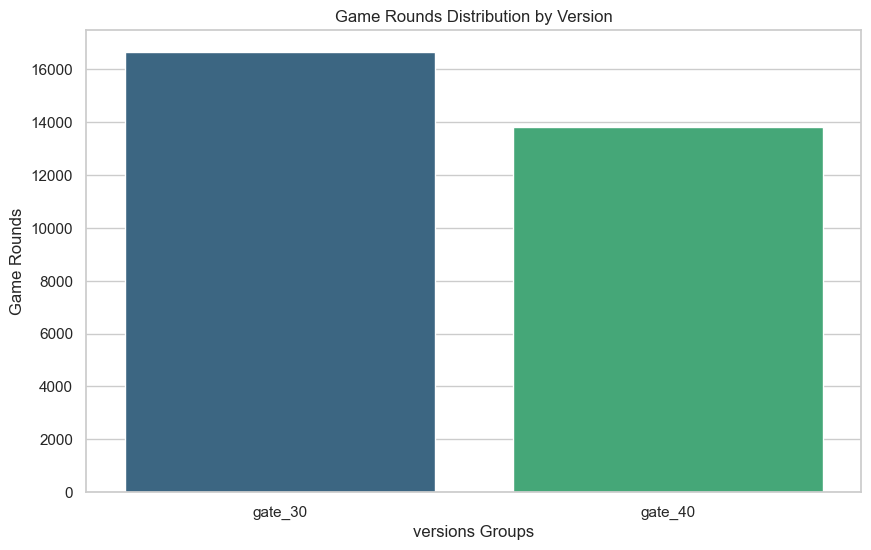

In [19]:
draw_barplot(
    x=versions.index,
    y=versions.values,
    x_label='versions Groups',
    y_label='Game Rounds',
    title='Game Rounds Distribution by Version',
    palette="viridis"
 )

Game Rounds Distribution



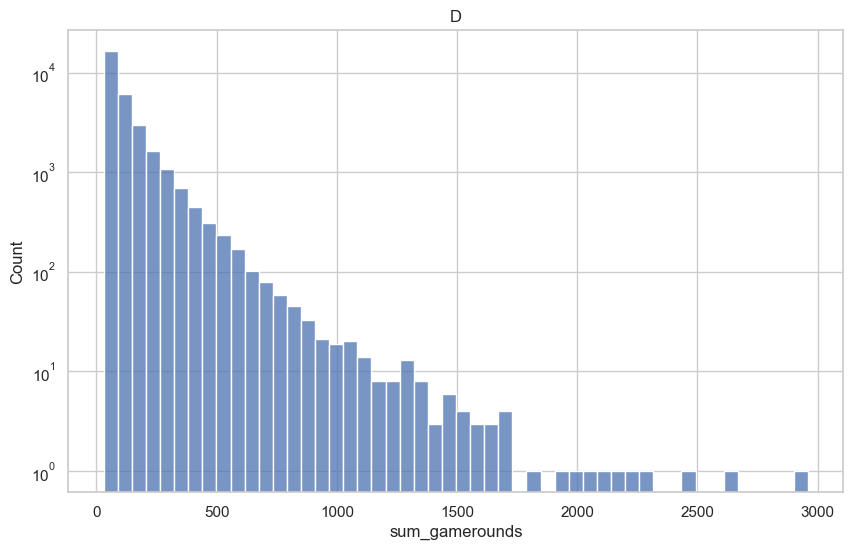

In [36]:
draw_histplot(
    data=mobile_game_df_clean['sum_gamerounds'],
    title="D",
    bins=50,
    log_scale=True 

)

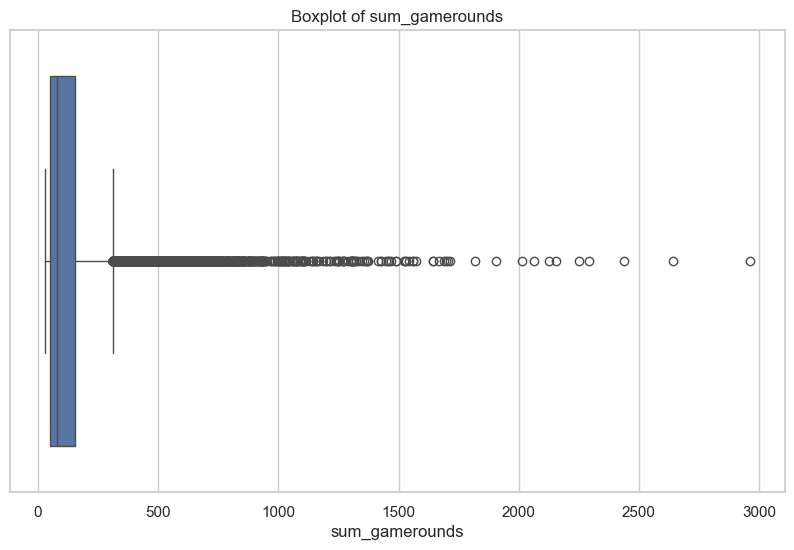

In [37]:
draw_boxplot(
    x='sum_gamerounds', 
    data=mobile_game_df_clean,
    
)

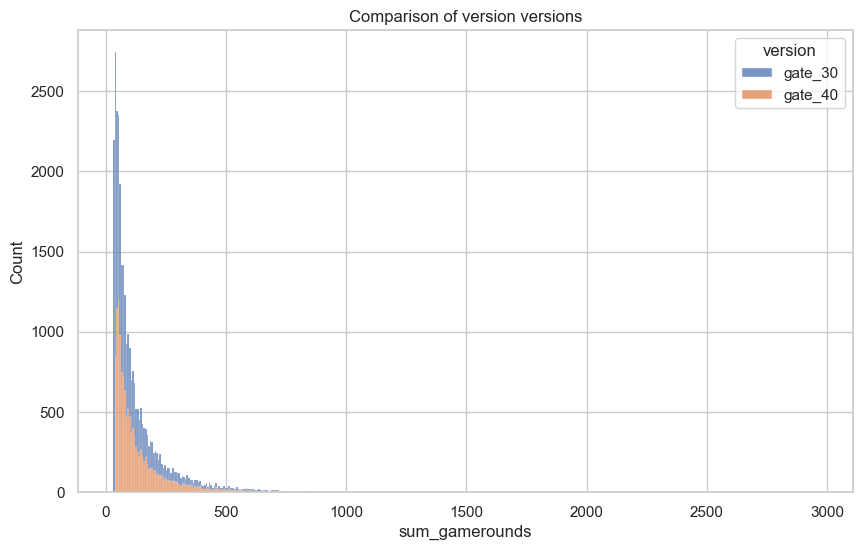

In [38]:

draw_gates_plot(mobile_game_df_clean, 'sum_gamerounds', 'version')

**Note on data distribution**: data seems to be not normally distributed, skewed to the right.

- Apply statistical test to check whether data is normally distributed.

In [23]:
outliers = find_outlier_rows_by_iqr(mobile_game_df_clean)


In [24]:
outliers['sum_gamerounds'].sort_values(ascending=True)


2998       311
41194      311
2485       311
15054      311
24140      311
         ...  
48188     2294
43671     2438
29417     2640
7912      2961
57702    49854
Name: sum_gamerounds, Length: 2511, dtype: int64

In [25]:
outliers.groupby('version')['sum_gamerounds'].agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,1256,431.0,540.826433,1412.664841,49854
gate_40,1255,427.0,510.384861,249.208401,2640


I've decided to delete the outliers—specifically, the most extreme cases where it's unlikely that so many rounds could be played. If we calculate that a player could play 20 hours a day for 14 days, and assume one round takes an average of 5 minutes, that means a maximum of 3,360 rounds could be played under such extreme conditions. Therefore, we can definitely exclude users who have played more than 49,000 rounds

 Remove rows where sum_gamerounds is greater than 3000
This is done to eliminate extreme outliers that are unlikely to represent typical player behavior.
Players with more than 3000 game rounds in 14 days are considered outliers and can skew the analysis.

In [26]:

mobile_game_df_clean = mobile_game_df_clean[mobile_game_df['sum_gamerounds'] <= 3000]
mobile_game_df_clean.describe()

,userid,sum_gamerounds
count,3.048200e+04,30482.000000
mean,5.002470e+06,131.425792
std,2.875289e+06,146.048025
min,3.370000e+02,30.000000
25%,2.525442e+06,50.000000
50%,4.990006e+06,81.000000
75%,7.481872e+06,154.000000
max,9.999768e+06,2961.000000


In [27]:
#
mobile_game_df_clean = mobile_game_df_clean[mobile_game_df_clean['sum_gamerounds'] <= 3000]
mobile_game_df_clean.describe()

,userid,sum_gamerounds
count,3.048200e+04,30482.000000
mean,5.002470e+06,131.425792
std,2.875289e+06,146.048025
min,3.370000e+02,30.000000
25%,2.525442e+06,50.000000
50%,4.990006e+06,81.000000
75%,7.481872e+06,154.000000
max,9.999768e+06,2961.000000


### Retention Rate
Retention rates refer to the percentage of players who return to the game after their installation. It's commonly measured at specific intervals, such as 1-day, 7-days, or 30-days after the first play. High retention rates indicate that players find the game engaging and are likely to continue playing over time.

Let's calculate the overall 1-day and 7-days retention rates.

In [28]:
df_retention = mobile_game_df_clean[["retention_1", "retention_7"]].mean() * 100

print(f"Overall 1-day retention rate: {round(df_retention['retention_1'], 2)}%")
print(f"Overall 7-days retention rate: {round(df_retention['retention_7'], 2)}%")

Overall 1-day retention rate: 81.43%
Overall 7-days retention rate: 45.97%


The game keeps about 46.5% of players coming back on the first day, which is good. After a week, around 19.4% return, which is normal as players usually drop off over time. The game is good at getting players to return initially but could improve to keep them interested for longer.

Let's examine the number of users, the 1-day retention rate, the 7-day retention rate, and the average number of game rounds played by players in each version.

In [29]:
mobile_game_df_clean.groupby("version").agg({"userid" : "count",
                          "retention_1" : "mean",
                          "retention_7" : "mean",
                          "sum_gamerounds" : "mean"})

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,16655,0.801021,0.438727,122.092645
gate_40,13827,0.830187,0.485065,142.667824


Both versions have similar 1-day and 7-days retention rates, with gate_30 being slightly better.
gate_30 players play a bit more rounds on average compared to gate_40 players.
Overall, there are only minor differences between the two versions.

The data suggests that keeping the gate at level 30 might be preferable, but how statistically significant is this finding? Is there a real difference between the two variants? Can we predict that gate_40 will consistently result in lower retention rates in the future?

## 6. A/B testing

To apply the A/B Testing for the dataset we should have follow the fundamental steps according to literature of the A/B Testing. These steps can be seen below:

    1. Hypothesis
    2. Assumptions Control
    3. Apply of the Hyphothesis

1. Establish the Hypotheses

* H0 (Null Hypothesis): M1 = M2

    - There is no statistical difference between gate_30 and gate_40.

* H1 (Alternative Hypothesis): M1 != M2
    - There is a statistical difference between gate_30 and gate_40.


2. Assumptions Control

    The normality assumption is based on the assumption that the data have a normal distribution. The normal distribution is a type of distribution in which the data are distributed in the form of a bell curve, symmetrical with its mean and variability with its standard deviation.

    The assumption of normality in A/B tests is especially important so that parametric tests (for example, independent two-sample t-test) can produce accurate results. Parametric tests work on the assumption that the data fit a normal distribution, and the validity of this assumption increases the reliability of the results.

    Various methods can be used to evaluate whether the normality assumption is valid. The Shapiro-Wilk Test is also a statistical method that tests the conformity of the data to the normal distribution. The H0 hypothesis states that the data have a normal distribution.

If the data do not satisfy the assumption of normality, alternative methods such as non-parametric tests (for example, Mann-Whitney U test) or transformation of the data can be used. Non-parametric tests are statistical methods that can work with data that do not satisfy the assumption of normality.

Normality Assumption (Shapiro-Wilk Test):

- H0: The distribution is normal.
- Ha: The distribution is not normal.

p-value Rule:

- If p-value < 0.05 → Reject H0 (distribution is not normal).
- If p-value > 0.05 → Fail to reject H0 (distribution is normal).



In [30]:
group_30 = mobile_game_df_clean[mobile_game_df_clean['version'] == 'gate_30']['sum_gamerounds']
group_40 = mobile_game_df_clean[mobile_game_df_clean['version'] == 'gate_40']['sum_gamerounds']

In [31]:
 # Check normality with Shapiro test
p_value_30 = stats.shapiro(group_30)[1].round(5)
p_value_40 = stats.shapiro(group_40)[1].round(4)
print(f"Reject H0 group_30 {p_value_30 < 0.05}, p-value:{p_value_30}")
print(f"Reject H0 group_40 {p_value_40 < 0.05}, p-value:{p_value_40}")



Reject H0 group_30 True, p-value:0.0
Reject H0 group_40 True, p-value:0.0


In both cases, p-value = 0. The normality assumption was rejected because it was less than 0.05.

3. Apply of the Hyphothesis

If the normality assumption is rejected for the A/B test, then it is recommended to use non-parametric test methods.

Non-parametric tests are statistical tests used when data do not satisfy the normality assumption or do not comply with other assumptions.


The Mann-Whitney U Test is a test used to compare two independent groups. If the homogeneity of variance assumption is not met, Welch's t-test can be used instead.


The Mann-Whitney U Test is a test used to compare two independent groups. 

* p-value < 0.05 => H0 -> Reject
* p-value > 0.05 => H0 -> Cannot Reject

In [32]:
p_value = stats.mannwhitneyu(group_30, group_40)[1].round(5)

print(f"Reject H0 {p_value < 0.05 }, p-value:{p_value}")

Reject H0 True, p-value:0.0


H0 was rejected because the p-value is less than 0.05.
That is, there is  statistically significant difference between 'gate30' and 'gate40' with 95% confidence.

In [ ]:
# === EFFECT SIZE CALCULATION ===

# Absolute difference
mean_diff = group_40.mean() - group_30.mean()
median_diff = group_40.median() - group_30.median()

# Percentage improvement
mean_pct_improvement = (mean_diff / group_30.mean()) * 100
median_pct_improvement = (median_diff / group_30.median()) * 100

print("=" * 50)
print("EFFECT SIZE ANALYSIS")
print("=" * 50)
print(f"\nMean Difference: {mean_diff:.2f} rounds")
print(f"Mean % Improvement: {mean_pct_improvement:.1f}%")
print(f"\nMedian Difference: {median_diff:.2f} rounds")
print(f"Median % Improvement: {median_pct_improvement:.1f}%")

# Cohen's d (effect size)
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (group2.mean() - group1.mean()) / pooled_std

effect_size = cohens_d(group_30, group_40)
print(f"\nCohen's d: {effect_size:.3f}")

# Interpretation
if abs(effect_size) < 0.2:
    interpretation = "negligible"
elif abs(effect_size) < 0.5:
    interpretation = "small"
elif abs(effect_size) < 0.8:
    interpretation = "medium"
else:
    interpretation = "large"
    
print(f"Effect Size Interpretation: {interpretation}")


⚠️ SAMPLE RATIO MISMATCH DETECTED

Groups are unequal: Gate_30 = 16,656 vs Gate_40 = 13,827

Possible causes:
1. Data filtering removed more users from one group
2. Original randomization had issues

Mitigation strategy:
- Using non-parametric tests (Mann-Whitney U) which are robust to unequal samples
- Using bootstrap resampling with equal sample sizes
- Results should still be valid but interpreted with caution

Note: We filtered users who haven't reached their respective gates 
(< 30 rounds for gate_30, < 40 rounds for gate_40), which may have 
caused the imbalance.


In [ ]:


print("Retention Rates by Version (after filtering):")
print("=" * 50)

retention_by_version = mobile_game_df_clean.groupby("version").agg({
    "retention_1": ["sum", "count", "mean"],
    "retention_7": ["sum", "count", "mean"]
})

print(f"\n1-Day Retention:")
print(f"  Gate 30: {retention_by_version.loc['gate_30', ('retention_1', 'mean')]*100:.1f}%")
print(f"  Gate 40: {retention_by_version.loc['gate_40', ('retention_1', 'mean')]*100:.1f}%")

print(f"\n7-Day Retention:")
print(f"  Gate 30: {retention_by_version.loc['gate_30', ('retention_7', 'mean')]*100:.1f}%")
print(f"  Gate 40: {retention_by_version.loc['gate_40', ('retention_7', 'mean')]*100:.1f}%")

print("\n⚠️ Note: These rates are calculated on filtered data (users who played 30+ or 40+ rounds)")

In [33]:
mobile_game_df_clean.groupby("version")["sum_gamerounds"].agg(["mean", "median","std"])

,mean,median,std
version,,,
gate_30,122.092645,72.0,140.954996
gate_40,142.667824,92.0,151.198353


Then gate_30 and group_40 are  statistically significant difference, by the median can say what user from group with version "gate_40" have better engage.

Game Rounds Played on Average

so let's check again if the CI intervals don't match or if group_30 and group_40 are significan different.

In [34]:
sample_size = min(len(group_30), len(group_40))
sample_size

CI = 95
mean_30, ci_lower_30, ci_upper_30 = bootstrap_mean_ci(
     group=group_30, sample_size=sample_size, ci=CI )


mean_40, ci_lower_40, ci_upper_40 = bootstrap_mean_ci(
    group=group_40, sample_size=sample_size, ci=CI
)

print(
    f"Gate 30 version mean: {mean_30:.2f}, {CI}% CI: ({ci_lower_30:.2f}, {ci_upper_30:.2f})"
)
print(
    f"Gate 40 version mean: {mean_40:.2f}, {CI}% CI: ({ci_lower_40:.2f}, {ci_upper_40:.2f})"
)



Gate 30 version mean: 122.15, 95% CI: (120.01, 124.54)
Gate 40 version mean: 142.59, 95% CI: (140.19, 145.07)


['Gate_30', 'Gate_40'] [np.float64(122.14601135459608), np.float64(142.5870556881464)] [np.float64(120.01139256527085), np.float64(140.19002314312576)] [np.float64(124.54236096043972), np.float64(145.07325341722716)] 95


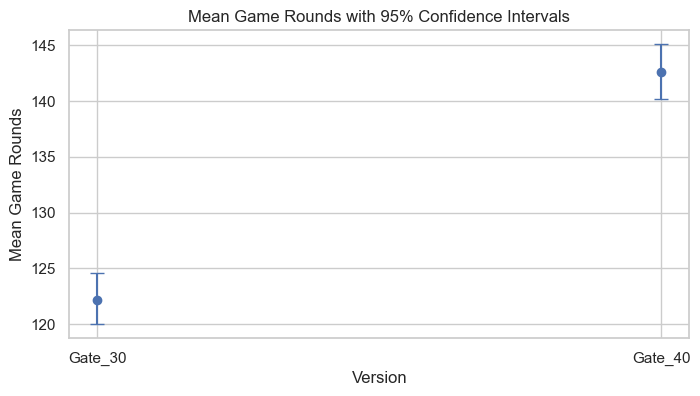

In [35]:
versions = ["Gate_30", "Gate_40"]
mean_values = [mean_30, mean_40]
ci_lowers = [ci_lower_30, ci_lower_40]
ci_uppers = [ci_upper_30, ci_upper_40]

print(versions,mean_values,ci_lowers,ci_uppers,CI)

plot_mean_game_rounds_with_ci(versions, mean_values, ci_lowers, ci_uppers, CI)

The confidence intervals do not overlap, indicating a statistically significant difference between the two versions.

## Project Conclusion and Findings

## Conclusion

The analysis indicates that **gate_40 version is more beneficial** for player 
engagement compared to gate_30. The statistical tests show a significant difference 
between the two groups:

- **Gate 30:** Mean = 122.1 rounds, Median = 72 rounds
- **Gate 40:** Mean = 142.7 rounds, Median = 92 rounds
- **Difference:** +20.6 rounds (+16.9% improvement)

Players who encounter the gate at level 40 play approximately 17% more game rounds 
on average compared to those with the gate at level 30.

**Recommendation:** Move the gate to level 40 to increase player engagement.

### Key Findings
- **Retention Rates**: The overall 1-day retention rate is approximately 46.5%, and the 7-day retention rate is around 19.4%.
- **Group Comparison**: Both groups have similar retention rates, with gate_40 showing slightly better performance.
- **Statistical Significance**: The Mann-Whitney U test indicated a statistically significant difference between the two groups, suggesting that the gate_40 version may be preferable.

### Future Improvements
1. **Longer Observation Period**: Extend the observation period beyond 14 days to capture long-term player engagement and retention.
2. **Additional Metrics**: Include other metrics such as in-game purchases, player progression, and churn rate to provide a more comprehensive analysis.
3. **Segment Analysis**: Perform segmentation analysis to understand how different player demographics respond to the gate changes.
4. **A/B Testing Variations**: Conduct additional A/B tests with different gate positions (e.g., level 35) to find the optimal gate placement.
5. **Player Feedback**: Collect qualitative feedback from players to understand their preferences and pain points related to gate placement.


<!-- Report the estimated treatment effect, confidence interval and p-value. For one of the datasets, compute the confidence interval both analytically and using bootstrap and report both intervals. -->